# 4D scan

In [5]:
import sys
import os
from os.path import join
from pprint import pprint
import importlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import pandas as pd
import h5py
from scipy import ndimage
import proplot as pplt

sys.path.append('..')
from tools import plotting as mplt
from tools import utils

In [6]:
pplt.rc['grid'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['cmap.discrete'] = False

## Load data 

In [3]:
datadir = '../Diagnostics/Data/Measurements/transverse4d/2022-07-02/'
filenames = os.listdir(datadir)
filenames

['220702154428-transverse4d.txt',
 '220702122854-transverse4d.h5',
 '220702122854-transverse4d.csv',
 '220702154428-transverse4d.png',
 '220702122854-transverse4d.png',
 '220702154428-transverse4d.csv',
 '220702122854-transverse4d.txt',
 '220702154428-transverse4d.h5']

In [4]:
filename = '220702154428-transverse4d'
file = h5py.File(join(datadir, filename + '.h5'), 'r')
print(list(file))

['config', 'log', 'scandata']


In [5]:
if 'config' in file:
    config = file['config']
    print(f"'config', {type(config)}")
    for key in config:
        print(f"  '{key}', {type(config[key])}")
        for name in config[key].dtype.names:
            print(f'    {name}: {config[key][name]}')
    # Make dictionary of metadata
    metadata = dict()
    for name in config['metadata'].dtype.names:
        metadata[name] = config['metadata'][name]
else:
    # Older measurement; metadata is in json file.
    metadata = json.load(open(join(datadir, filename + '-metadata.json'), 'r'))
    _metadata = dict()
    for _dict in metadata.values():
        for key, value in _dict.items():
            _metadata[key] = value
    metadata = _metadata
    pprint(metadata)

'config', <class 'h5py._hl.group.Group'>
  'environment', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65679107e+09]
    user: [b'46h']
    host: [b'btf-diag-app1.ics.sns.gov']
    cmd_line: [b'scan4d/transverse4d.py']
    work_dir: [b'/home/46h/btf-scripts']
  'metadata', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65679108e+09]
    Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
    RFTF_TM:Gate_BeamOn:RR: [5.]
    BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
    BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
    BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
    BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
    BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
    BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
    BTF_MEBT_Mag:PS_QV07:I_Set: [-3.0999999]
    BTF_MEBT_Mag:PS_QH08:I_Set: [4.0999999]
    BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
    BTF_MEBT_Mag:PS_QV10:I_Set: [-1.89999998]
    BTF_MEBT_Mag:PS_QH11:I_Set: [7.19999981]
    BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55000019]
    BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
    BTF_MEBT_Mag:PS_QH33

In [6]:
if 'log' in file:
    log = file['log']
    print(f"'log', {type(log)}")
    for item in log.dtype.fields.items():
        print('  ', item)

    print('\nErrors and warnings:')
    for i in range(log.size):
        if not(log[i, 'level'] == 'INFO'.encode('utf')):
            timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
            print(f"{timestr} {log[i, 'message']}")

'log', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('level', (dtype('S15'), 8))
   ('source', (dtype('S20'), 23))
   ('message', (dtype('S512'), 43))

Errors and warnings:


In [7]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('bcm04_Current', (dtype('<f8'), 16))
   ('cam06_Integral', (dtype('<f8'), 24))
   ('cam06_Saturation', (dtype('<f8'), 32))
   ('xp_PositionSync', (dtype('<f8'), 40))
   ('x_PositionSync', (dtype('<f8'), 48))
   ('yp_PositionSync', (dtype('<f8'), 56))
   ('y_PositionSync', (dtype('<f8'), 64))


In [8]:
acts = ['xp_PositionSync', 'x_PositionSync', 'yp_PositionSync', 'y_PositionSync']

## Scan overview 

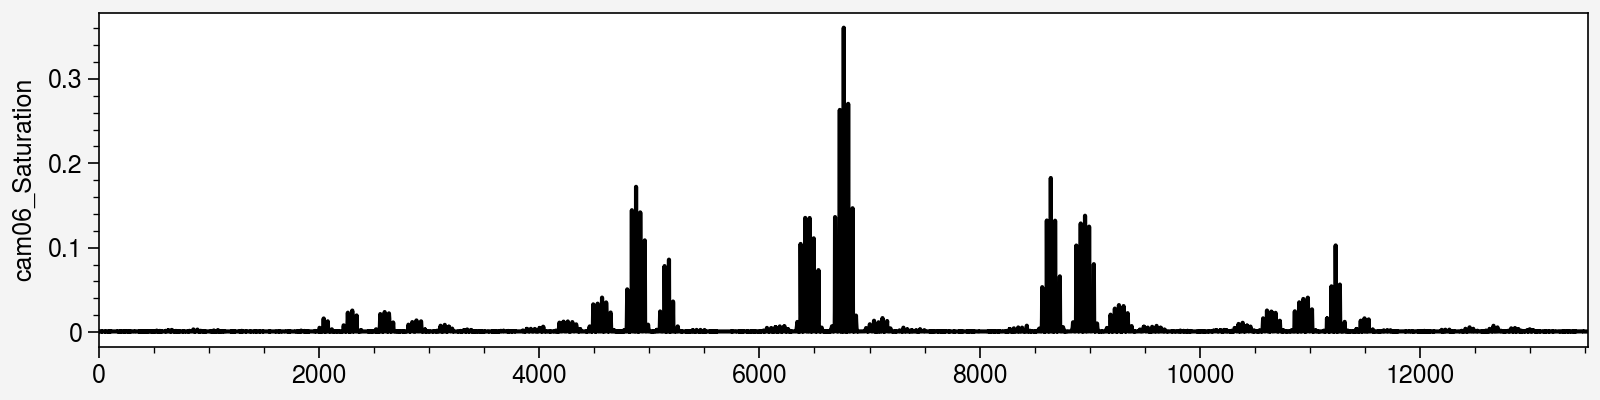

In [9]:
fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.plot(data['cam06_Saturation'], color='black')
ax.format(ylabel='cam06_Saturation')

### Data collection frequency

In [10]:
duration = data[-1, 'timestamp'] - data[0, 'timestamp']
iteration_duration = duration / data[-1, 'iteration']
points_per_iteration = len(data) / data[-1, 'iteration']
print(f'{len(data)} points recorded over {duration:.1f} seconds ({(duration / 3600.0):.1f} hours)')
print(f"Number of iterations: {data[-1, 'iteration']}")
print(f'Effective rep rate: {(len(data) / duration):.2f} Hz')
print(f'Time per iteration: {iteration_duration:.2f} seconds')
print(f'Points per iteration: {points_per_iteration:.2f}')

13524 points recorded over 4067.9 seconds (1.1 hours)
Number of iterations: 461
Effective rep rate: 3.32 Hz
Time per iteration: 8.82 seconds
Points per iteration: 29.34


Look for long pauses during data collection.

reprate = 5.00 Hz
Pauses longer than 30 seconds:
[]
Most pauses are 3.00 seconds


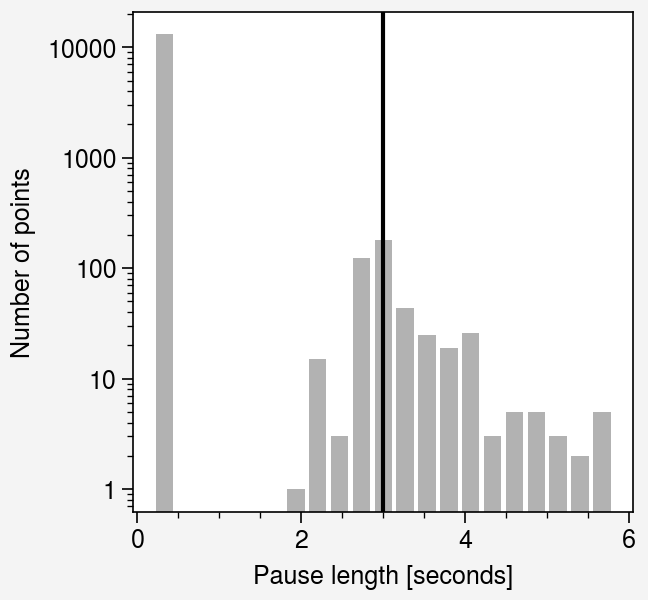

In [11]:
dt = np.diff(data[:, 'timestamp'])
rep_rate = 1.0 / np.median(dt)
print(f'reprate = {rep_rate:.2f} Hz')

print('Pauses longer than 30 seconds:')
long_pause = 30.0
print(dt[dt > long_pause])
dt[dt > long_pause] = 0.2

hist, bins = np.histogram(dt, bins=21)
idx_bins = np.digitize(dt, bins)
idx_pause, = np.where(idx_bins > 1)
median_pause = np.median(dt[idx_pause])
print(f'Most pauses are {median_pause:.2f} seconds')

fig, ax = pplt.subplots()
ax.bar(0.5 * (bins[1:] + bins[:-1]), hist, color='black', alpha=0.3)
ax.axvline(median_pause, color='black')
ax.format(xlabel='Pause length [seconds]', ylabel='Number of points', yscale='log')
# plt.savefig('_output/pauses.png')

### BCM current

In [12]:
bcm = 'bcm04_Current'
bcm_limit = 24.0  # [mA]
bcm_data = np.copy(data[bcm])

idx = np.arange(len(data))
idx_mask, = np.where(data[bcm] > -bcm_limit)
idx_valid, = np.where(~np.isin(idx, idx_mask))

print(f'Average BCM current (before masking) = {np.mean(bcm_data):.3f} +- {np.std(bcm_data):.3f} [mA]')
for i in idx_mask:
    print(f'Point {i} masked due to {bcm} current < {bcm_limit:.3f} [mA]')
print(f'Average BCM current (after masking) = {np.mean(bcm_data[idx_valid]):.3f} +- {np.std(bcm_data[idx_valid]):.3f} [mA]')

Average BCM current (before masking) = -29.134 +- 0.135 [mA]
Point 1932 masked due to bcm04_Current current < 24.000 [mA]
Average BCM current (after masking) = -29.135 +- 0.073 [mA]


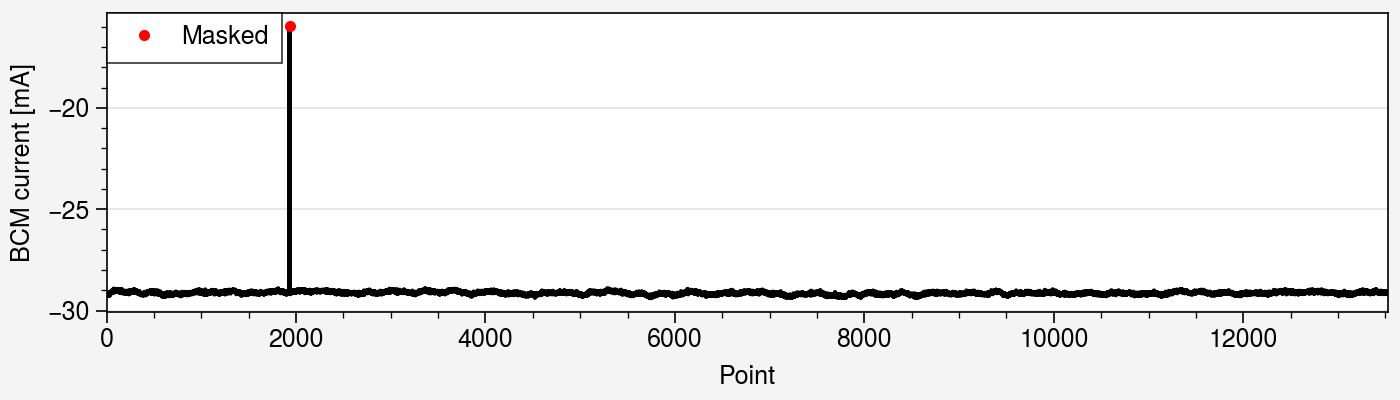

In [13]:
fig, ax = pplt.subplots(figsize=(7.0, 2.0))
ax.plot(bcm_data[idx], color='black')
ax.plot(idx_mask, bcm_data[idx_mask], color='red', lw=0, marker='.', label='Masked')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
ax.legend(loc='upper left')
# plt.savefig('_output/bcm_mask.png')
plt.show()

### Slit positions 

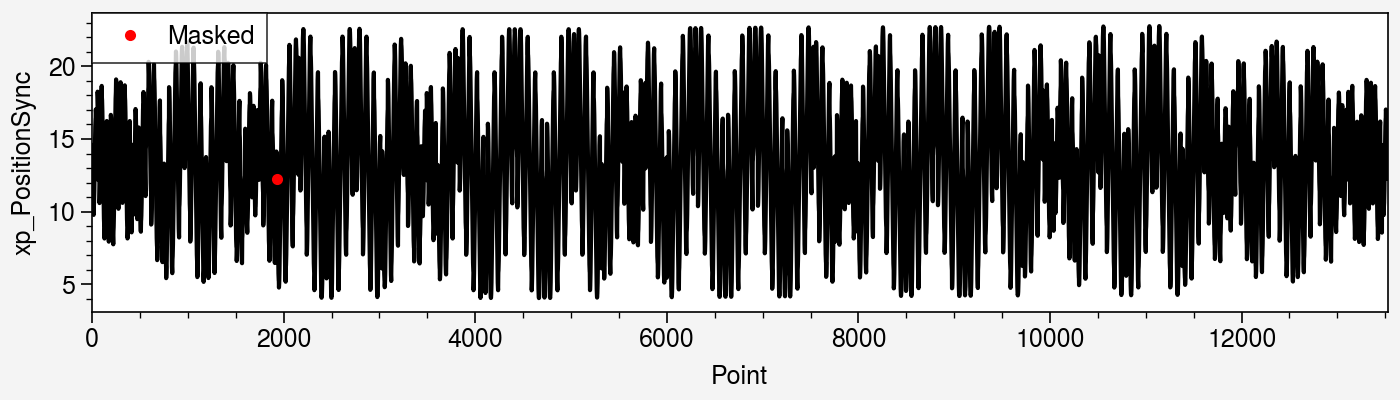

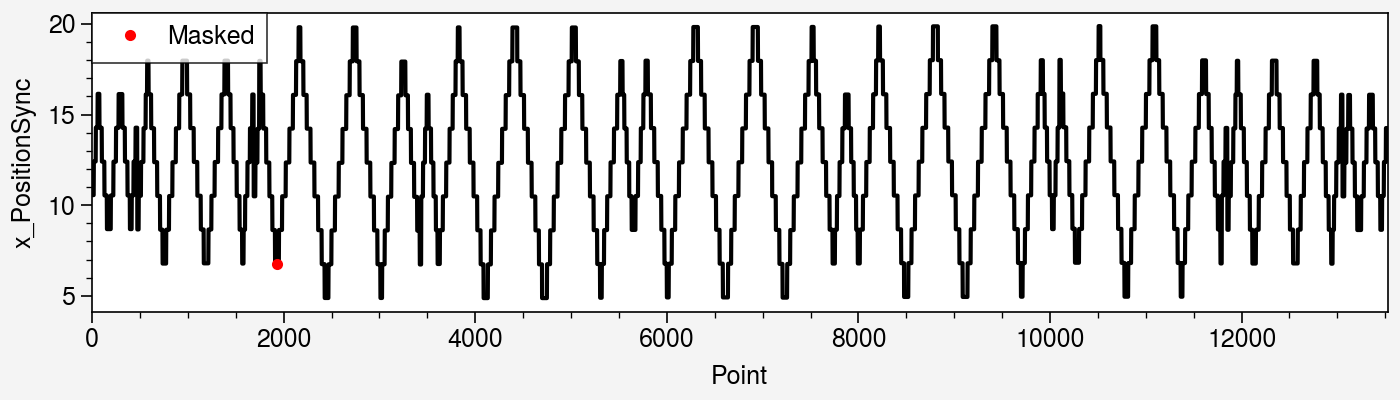

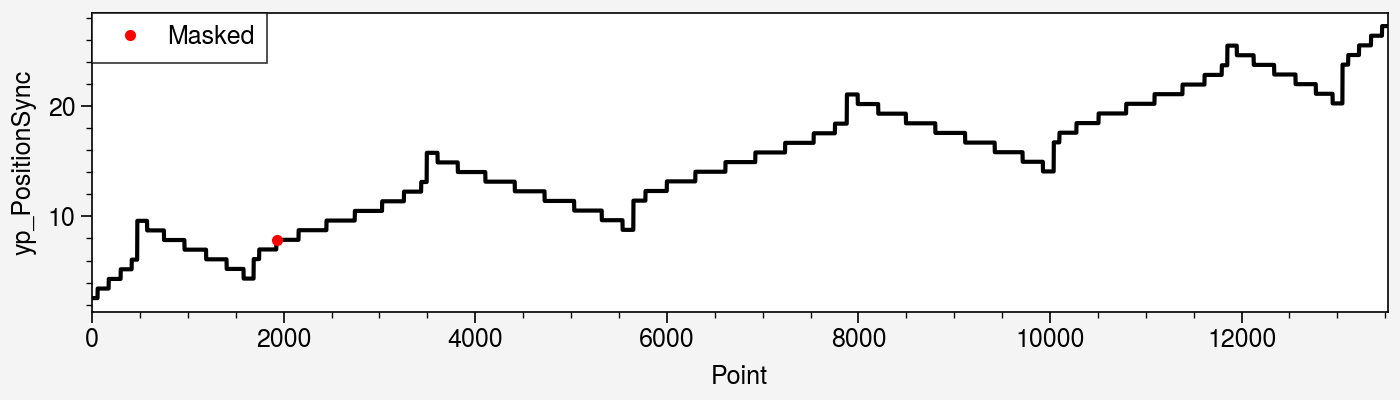

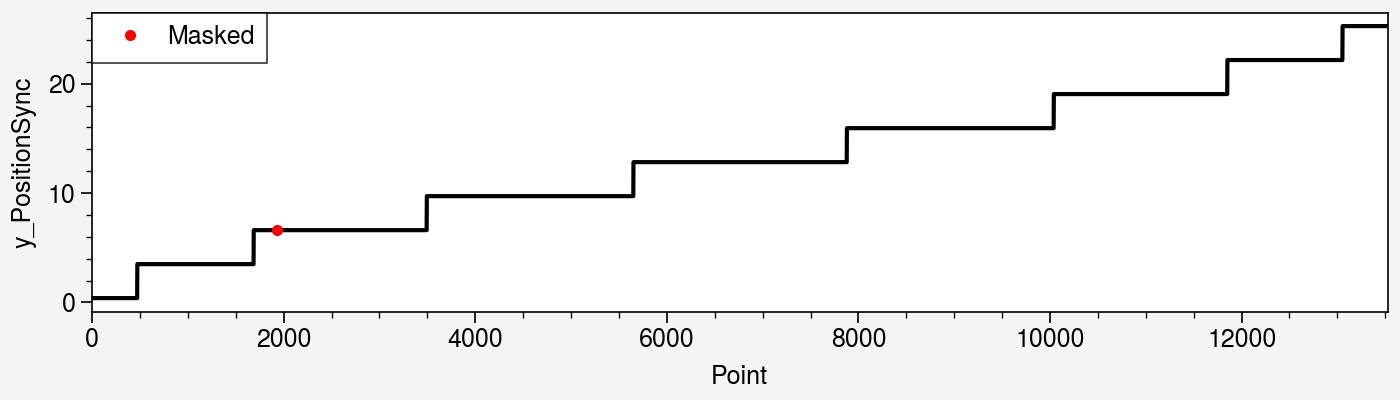

In [14]:
for act in acts:
    fig, ax = pplt.subplots(figsize=(7.0, 2.0))
    ax.plot(idx, data[idx, act], color='black')
    ax.plot(idx_mask, data[idx_mask, act], color='red', lw=0, marker='.', label='Masked')
    ax.format(xlabel='Point', ylabel=act)
    ax.legend(loc='upper left')
#     plt.savefig('_output/acts_mask.png')
    plt.show()

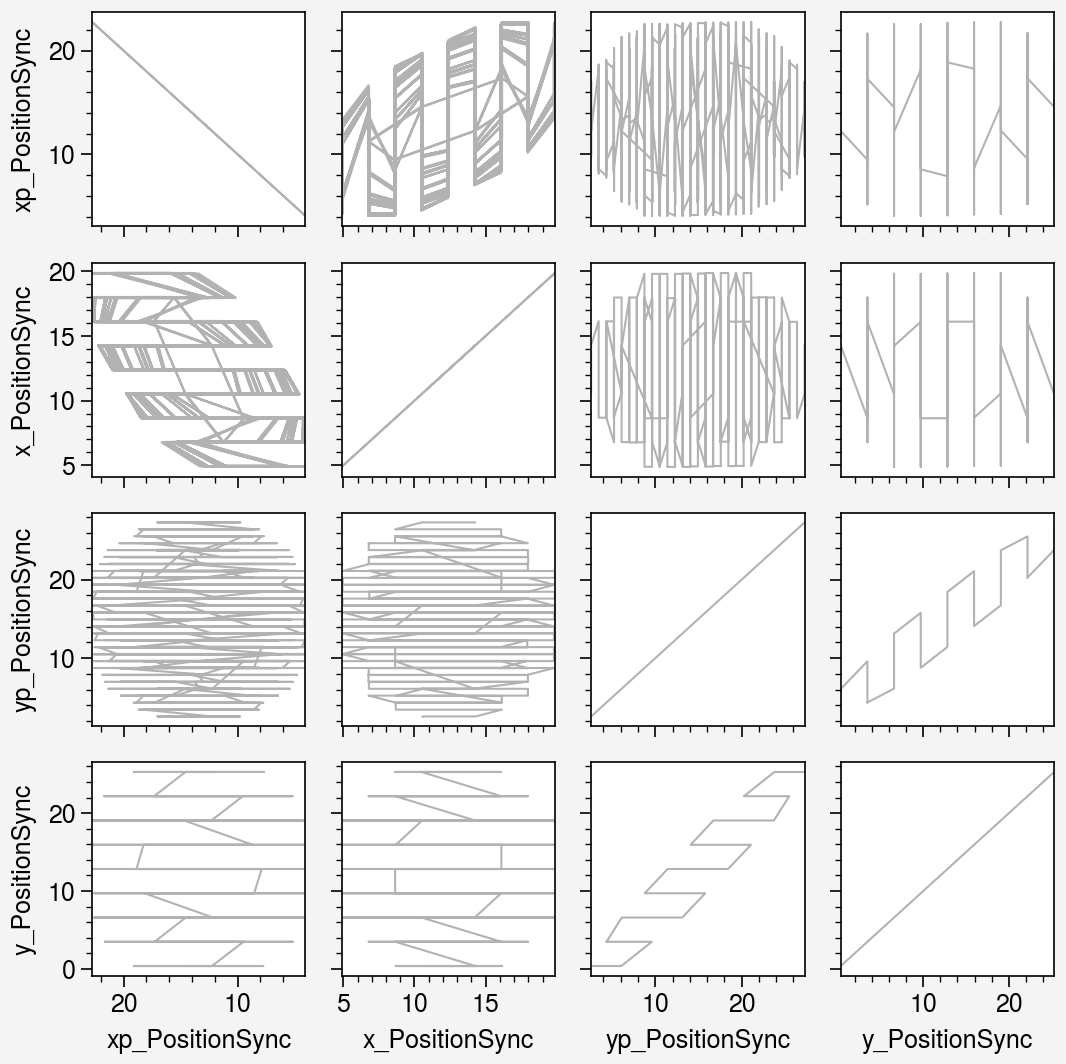

In [15]:
fig, axes = pplt.subplots(nrows=len(acts), ncols=len(acts), figwidth=4.0*len(acts)/3, 
                          spanx=False, spany=False, aligny=True)
for i in range(len(acts)):
    for j in range(len(acts)):
        ax = axes[i, j]
        x = data[acts[j]]
        y = data[acts[i]]
        ax.plot(x, y, color='black', alpha=0.3, lw=0.75)
for i, act in enumerate(acts):
    axes[-1, i].set_xlabel(act)
    axes[i, 0].set_ylabel(act)
# plt.savefig('_output/slit_correlations.png')
plt.show()

In [16]:
slit_dict = {
    'xp': {
        'pvname': 'ITSF_Diag:Slit_VT06',
        'center': 13.25,
        'distance': 15.0,
        'steps': 8,
        'min': +4.0,
        'max': +22.5,
    },
    'x': {
        'pvname': 'ITSF_Diag:Slit_VT04',
        'center': 12.5,
        'distance': 15.0,
        'steps': 8,
        'min': -50.0, 
        'max': +50.0,
    },
    'yp': {
        'pvname': 'ITSF_Diag:Slit_HZ06',
        'center': 15.0,
        'distance': 7.0,
        'steps': 8,
        'min': -50.0,
        'max': +50.0,
    },
    'y': {
        'pvname': 'ITSF_Diag:Slit_HZ04',
        'center': 13.0,
        'distance': 25.0,
        'steps': 8,
        'min': -50.0, 
        'max': +50.0,
    },
}
keys = list(slit_dict)

M = np.identity(4)
M[keys.index('xp'), keys.index('x')] = 0.65
M[keys.index('yp'), keys.index('y')] = 0.85  
Minv = np.linalg.inv(M)

center = np.array([slit_dict[key]['center'] for key in keys])
distance = np.array([slit_dict[key]['distance'] for key in keys])
steps = np.array([slit_dict[key]['steps'] for key in keys])

In [17]:
points = np.array([data[act].copy() for act in acts]).T
points_n = utils.apply(Minv, points - center)
points_nn = points_n / (0.5 * distance)

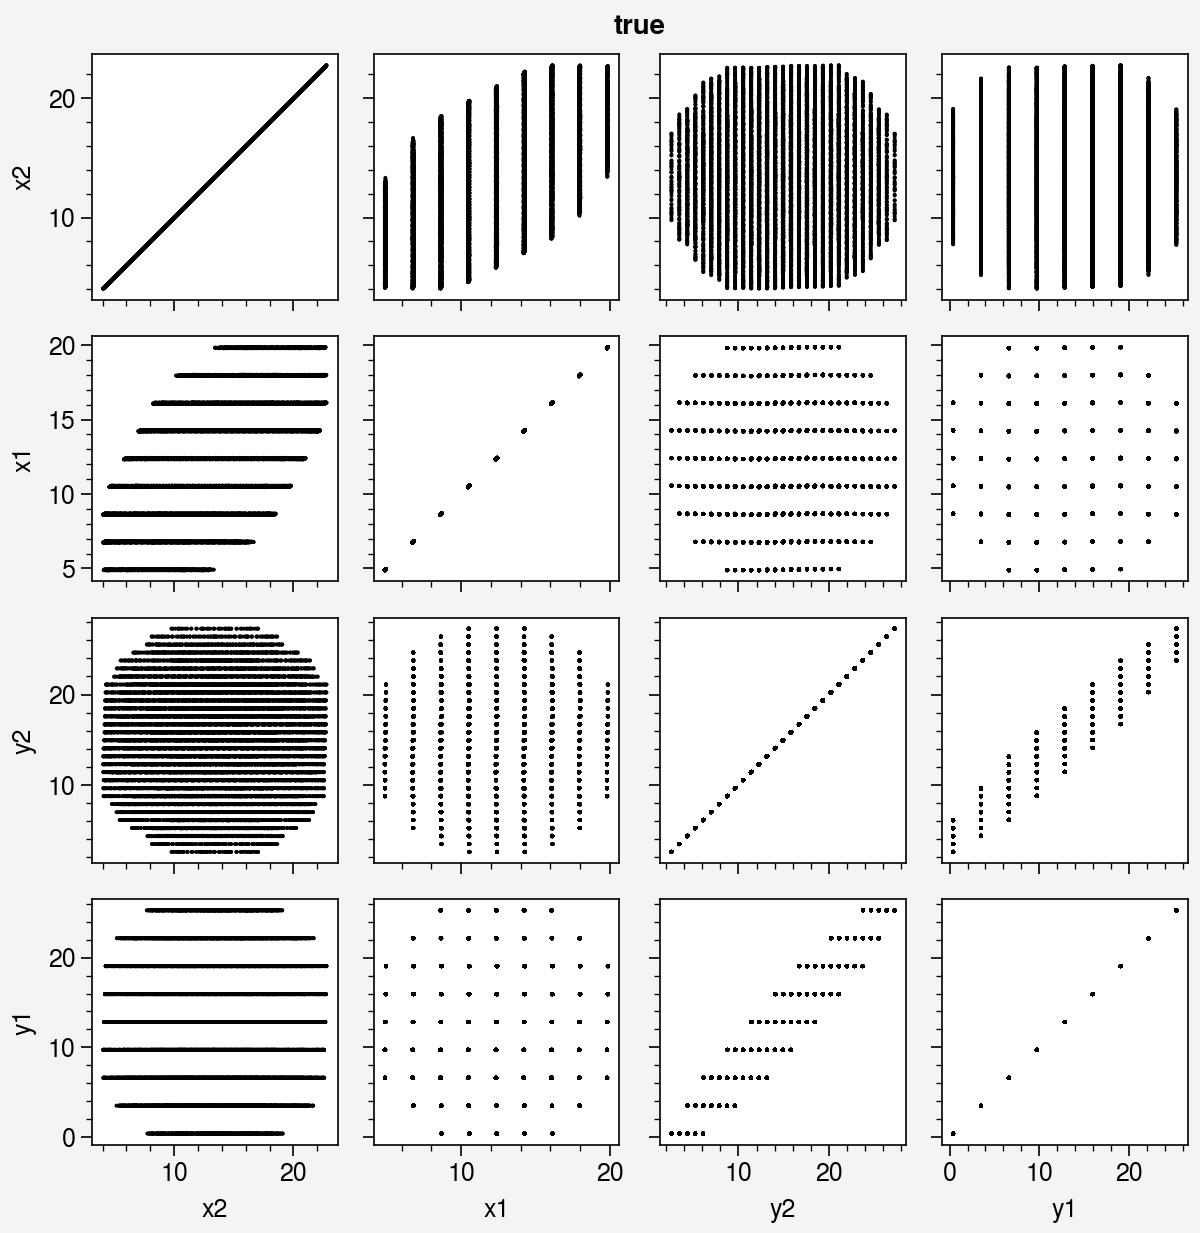

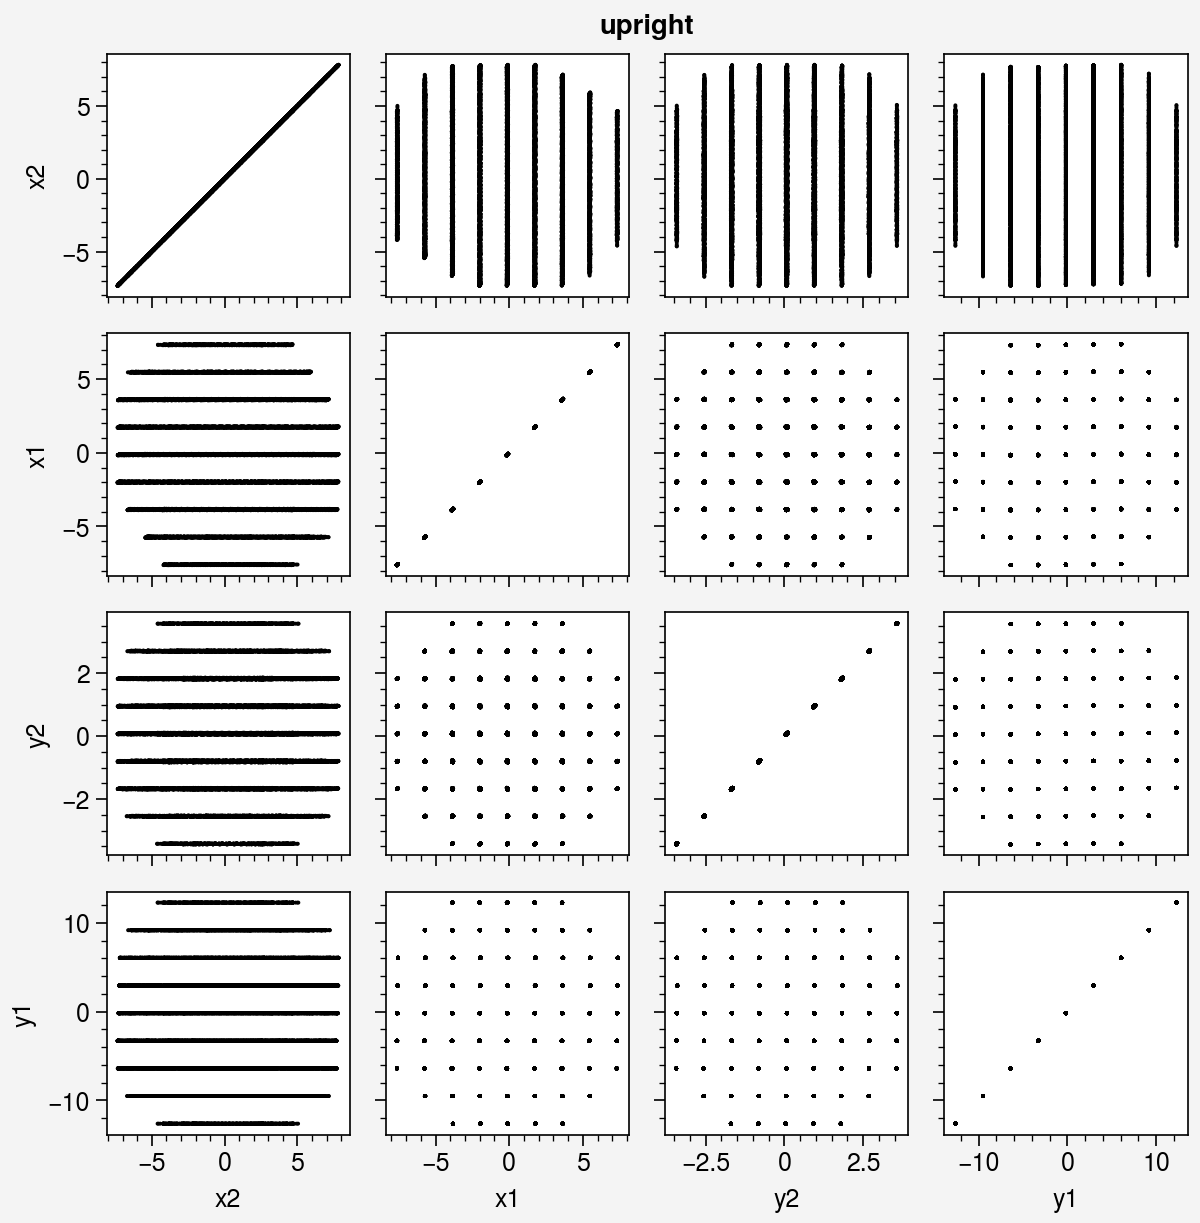

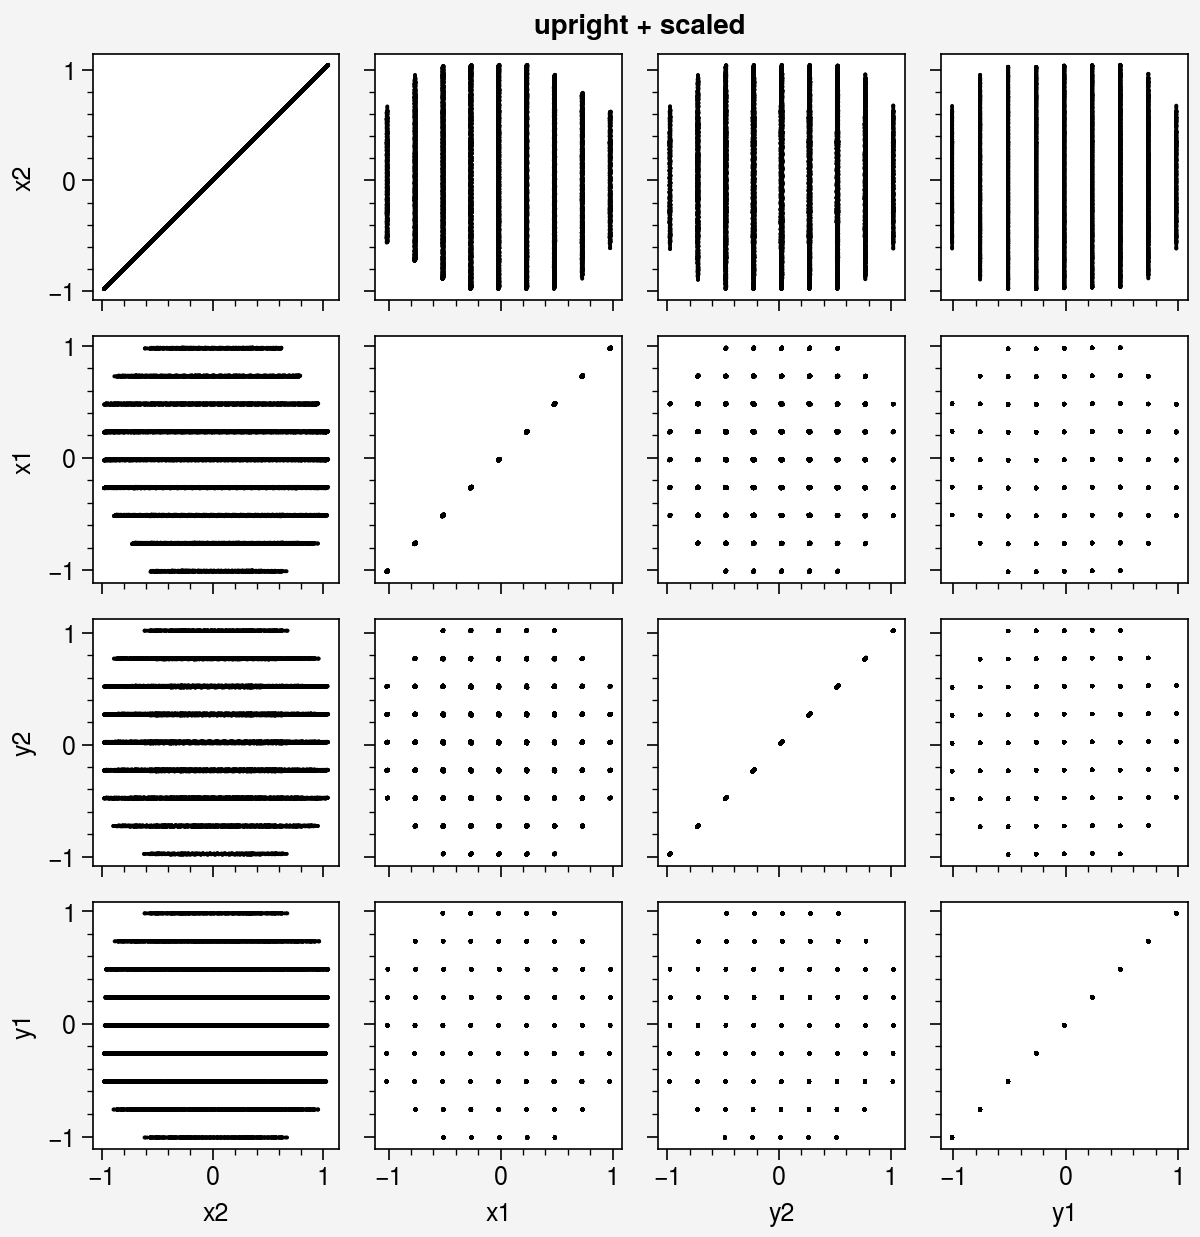

In [18]:
dims = ['x2', 'x1', 'y2', 'y1']
for _points, title in zip((points, points_n, points_nn), ('true', 'upright', 'upright + scaled')):
    fig, axes = pplt.subplots(ncols=4, nrows=4, figwidth=6.0, spanx=False, spany=False)
    axes.format(suptitle=title)
    for i in range(4):
        for j in range(4):
            axes[i, j].scatter(_points[:, j], _points[:, i], c='black', ec='None', s=2)
        axes[i, 0].format(ylabel=dims[i])
        axes[-1, i].format(xlabel=dims[i])
    plt.show()

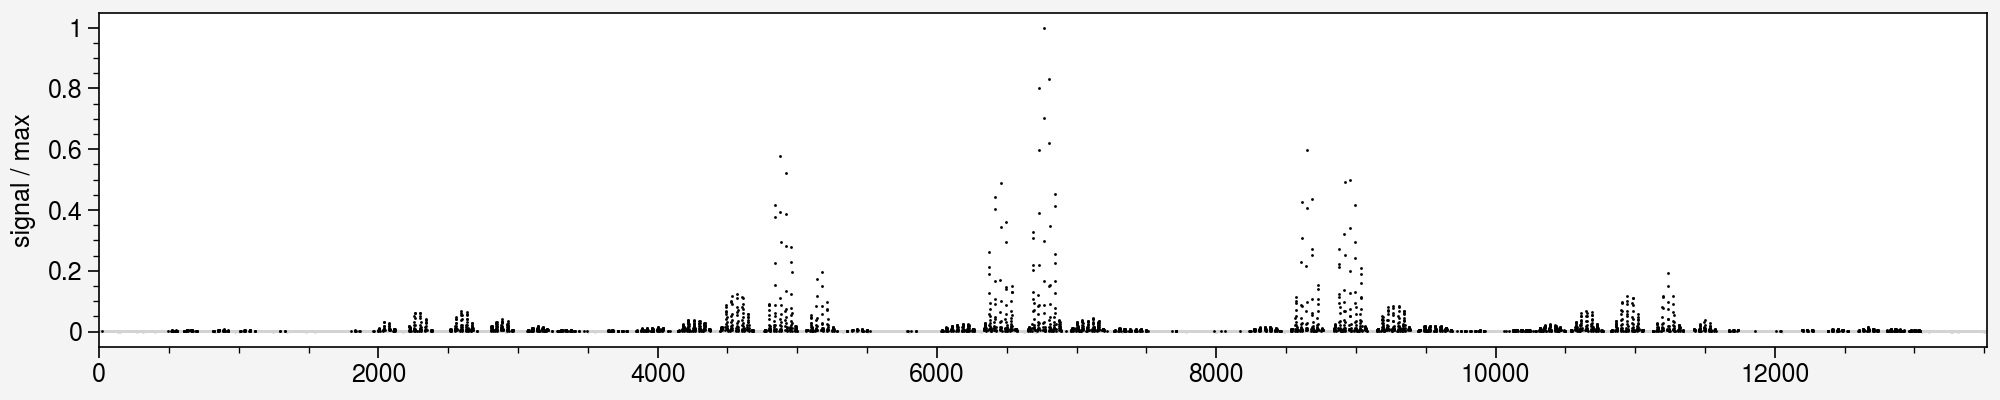

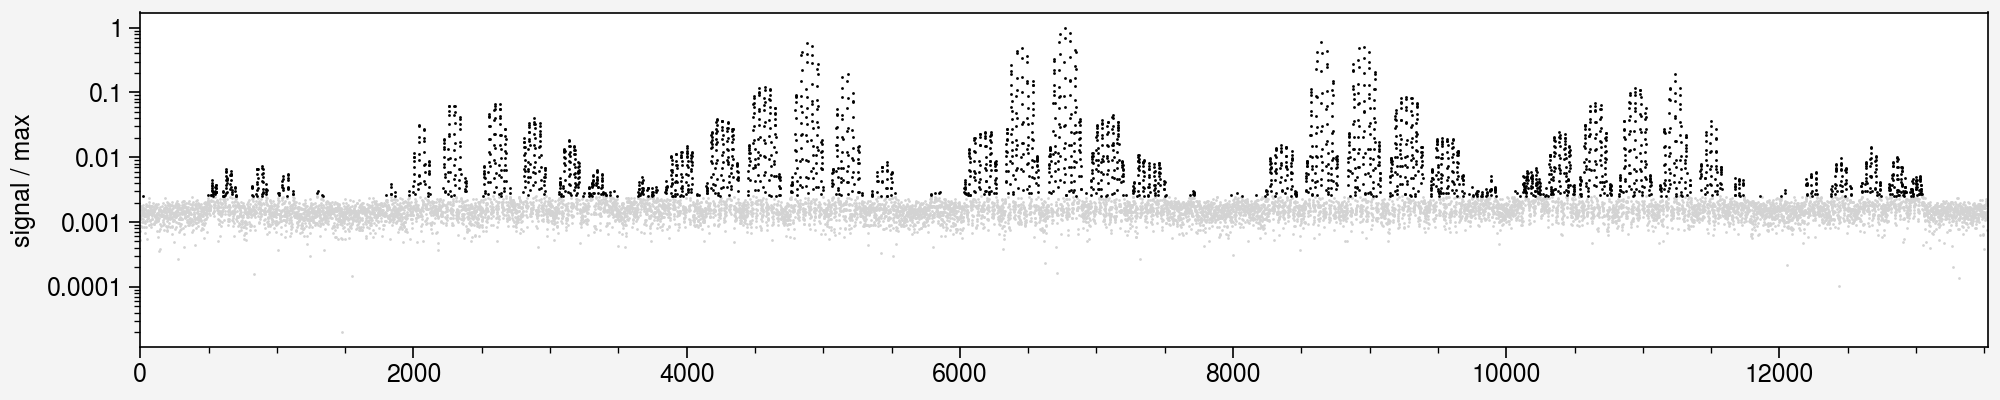

In [33]:
signal = data['cam06_Integral'].copy()
signal = signal - np.min(signal)
signal = signal / np.max(signal)
thresh = 0.0025
idx, = np.where(signal >= thresh)

for ax, norm in zip(axes, [None, 'log']):
    fig, ax = pplt.subplots(figsize=(10.0, 2.0))
    ax.plot(signal, color='lightgray', lw=0, marker='.', ms=2, ec='None')
    ax.plot(idx, signal[idx], color='black', lw=0, marker='.', ms=2, ec='None')
    ax.format(ylabel='signal / max')
    ax.format(yscale=norm)
    plt.savefig(f'_output/thresh_{norm}.png')
    plt.show()

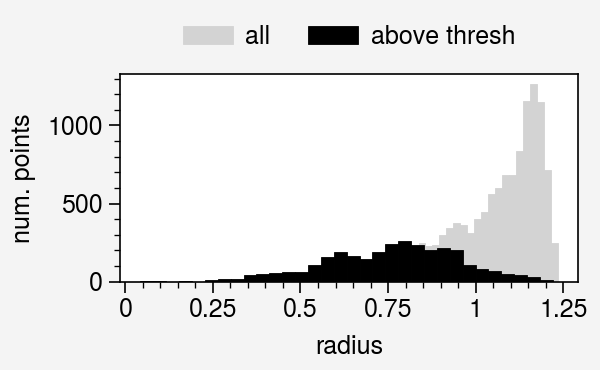

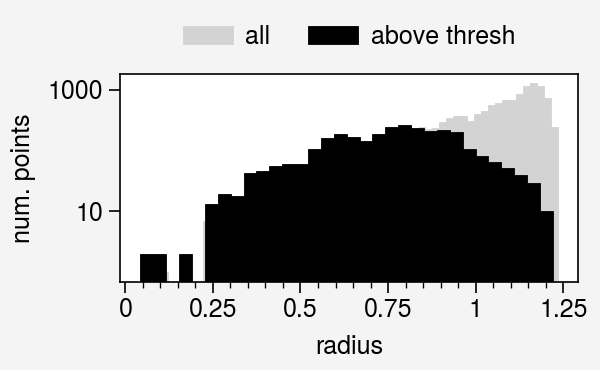

In [20]:
radii = np.sqrt(np.sum(np.square(points_nn), axis=1))

bins = 'auto'
for yscale in [None, 'log']:
    with pplt.rc.context(legendfontsize='medium'):
        fig, ax = pplt.subplots(figsize=(3, 1.85))
        ax.hist(radii, bins=bins, label='all', color='lightgrey')
        ax.hist(radii[idx], bins=bins, label='above thresh', color='black')
        ax.format(ylabel='num. points', xlabel='radius', yscale=yscale)
        ax.legend(ncols=2, loc='top', framealpha=0)
        plt.savefig(f'_output/radii_yscale{yscale}.png')
        plt.show()

In [21]:
rmax = np.max(radii[idx])

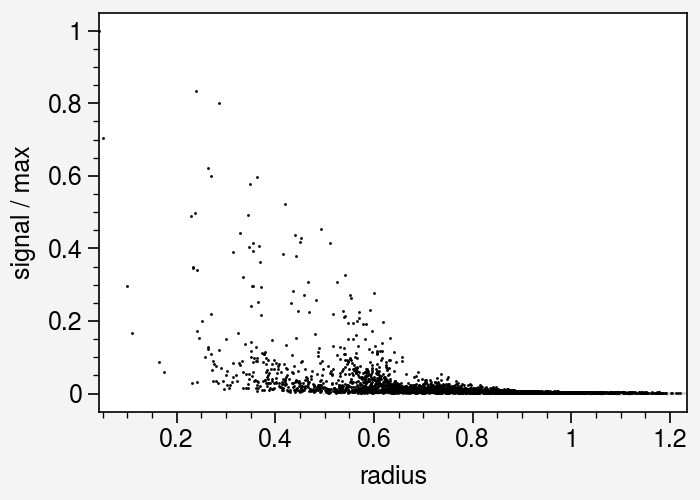

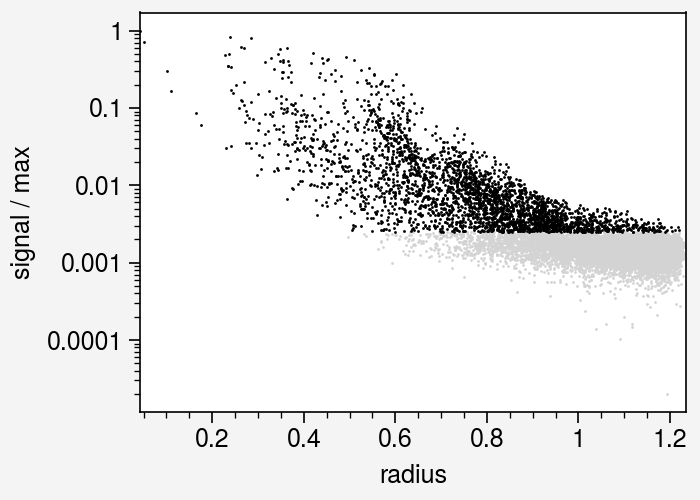

In [22]:
_sort = np.argsort(radii)
_radii = radii[_sort]
_signal = signal[_sort]
_idx, = np.where(_signal >= thresh)
kws = dict(lw=0, marker='.', ms=2, ec='None')
for norm in [None, 'log']:
    fig, ax = pplt.subplots(figsize=(3.5, 2.5))
    ax.plot(_radii, _signal, color='lightgray', **kws)
    ax.plot(_radii[_idx], _signal[_idx], color='black', **kws)
    ax.format(xlabel='radius', ylabel='signal / max')
    ax.format(yscale=norm)
    plt.savefig(f'_output/radii_scatter_{norm}.png')
    plt.show()

{'ycolor': 'red'}


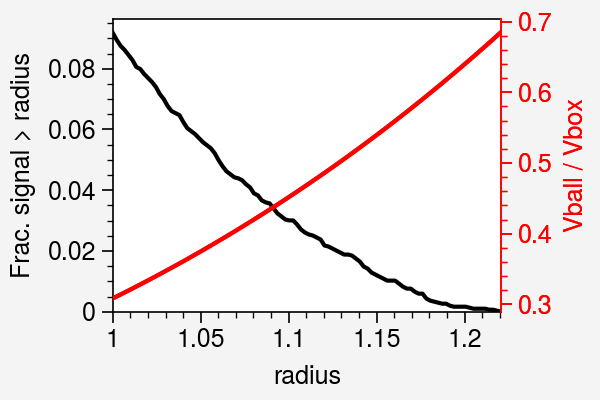

In [23]:
counts = []
rs = np.linspace(1.0, rmax, 100)
for r in rs:
    count = np.count_nonzero((np.logical_and(signal >= thresh, radii > r)))
    counts.append(count)
counts = np.array(counts)

fig, ax = pplt.subplots(figsize=(3, 2))
ax.plot(rs, counts / len(idx), color='black')
ax.format(xlabel='radius', ylabel='Frac. signal > radius')
ax.format(ylim=(0, ax.get_ylim()[1]))
ax1 = ax.alty(color='red')
ax1.plot(rs, utils.volume_sphere(n=4, r=rs) / utils.volume_box(n=4, r=1.0), color='red')
ax1.format(ylabel='Vball / Vbox')
# ax.format(yscale='log')
plt.savefig('_output/savings.png')

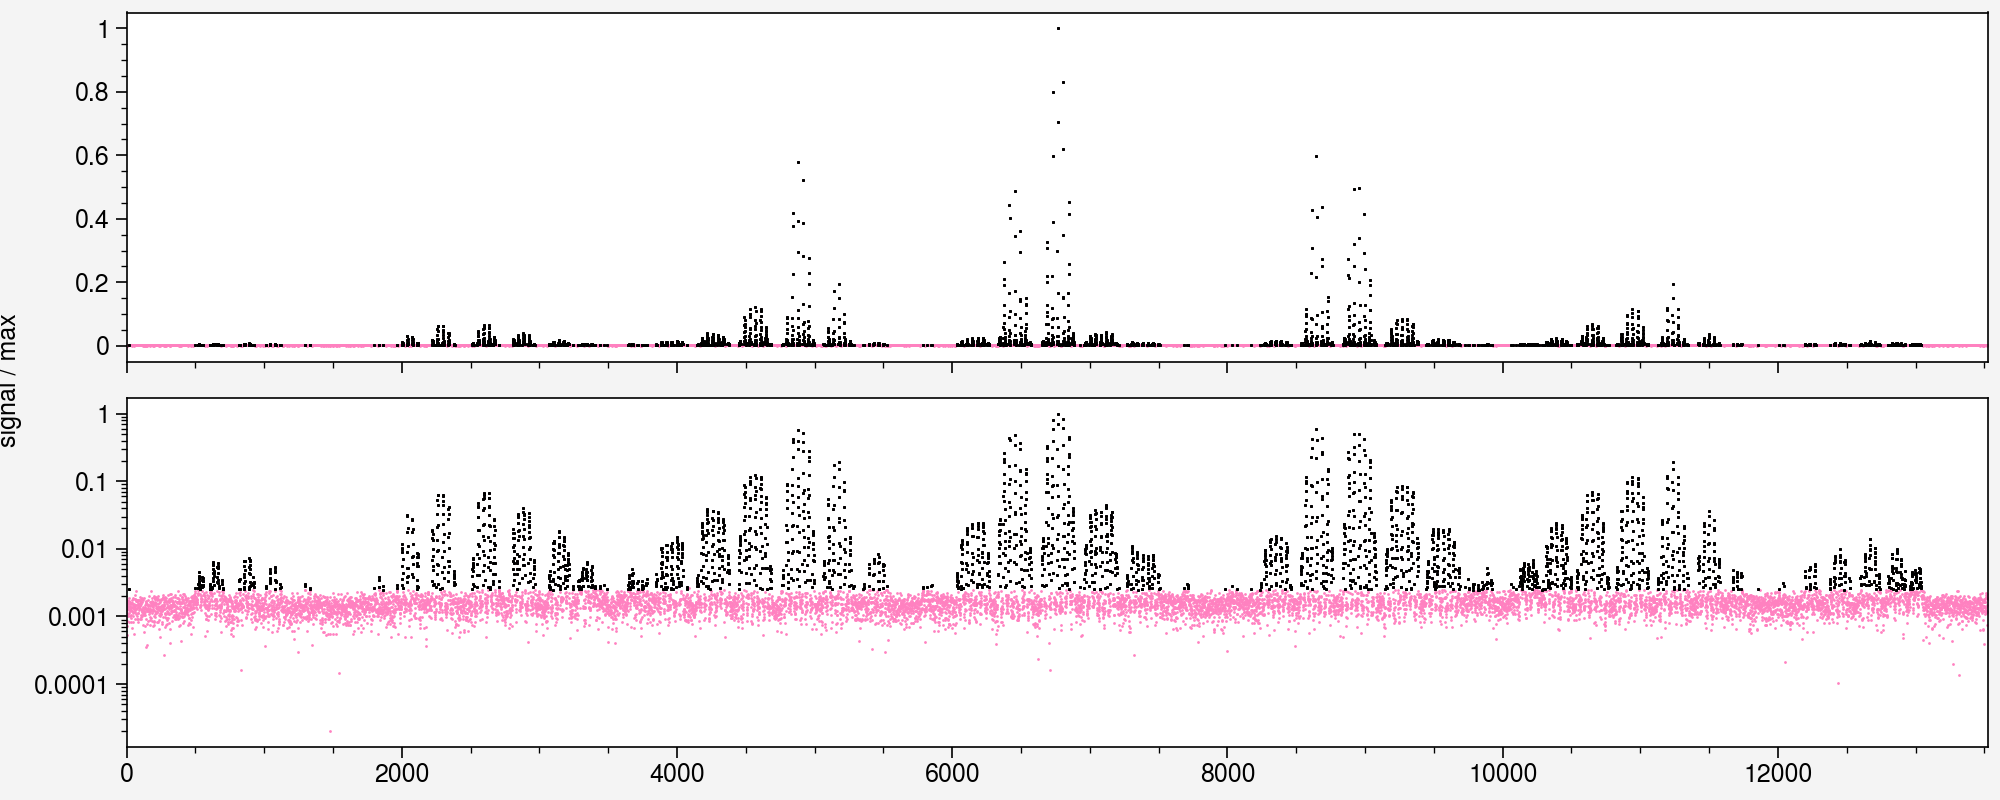

In [24]:
_idx, = np.where(np.logical_and(signal >= thresh, radii < rmax))

fig, axes = pplt.subplots(figsize=(10.0, 4.0), nrows=2)
for ax, norm in zip(axes, [None, 'log']):
    ax.plot(signal, color='pink', lw=0, marker='.', ms=2, ec='None')
    ax.plot(_idx, signal[_idx], color='black', lw=0, marker='+', ms=0.5)
    ax.format(ylabel='signal / max')
    ax.format(yscale=norm)
plt.show()

In [25]:
frac = np.count_nonzero(radii <= rmax) / len(radii)
frac

0.992309967465247

In [26]:
frac_signal = float(len(signal[idx])) / len(signal)
print(f'{frac_signal:.3f}')

0.224


In [27]:
volume_ratio = utils.volume_sphere(n=4, r=rmax) / utils.volume_box(n=4, r=1.0)
print(volume_ratio)

0.6848258175371302


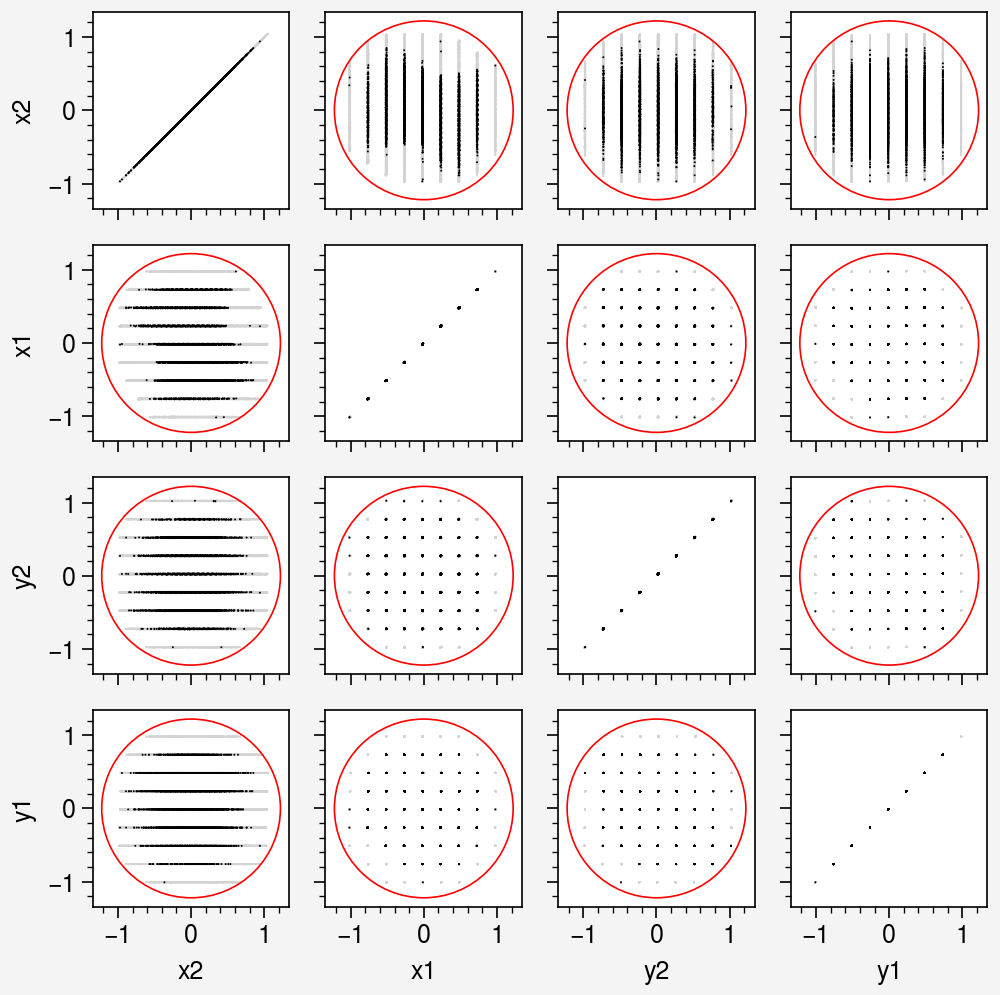

In [32]:
_points = points_nn
_rmax = rmax

fig, axes = pplt.subplots(ncols=4, nrows=4, figwidth=5.0, spanx=False, spany=False)
# axes.format(suptitle=f'fraction (r < {rmax:.2f}) = {frac:.2f}',
#             suptitle_kw=dict(fontweight='normal'))
for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        ax.scatter(_points[:, j], _points[:, i], c='lightgray', ec='None', s=0.5)
        ax.scatter(_points[idx, j], _points[idx, i], c='black', ec='None', s=0.5)
        if i != j:
            ax.add_patch(patches.Ellipse((0.0, 0.0), 2.0 * _rmax, 2.0 * _rmax, color='red', fill=False))
    axes[i, 0].format(ylabel=dims[i])
    axes[-1, i].format(xlabel=dims[i])
plt.savefig('_output/bounding_ellipse.png')
plt.show()